## Dataset Download

In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## Library Imports

In [6]:
import cv2
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Resizing, Rescaling, Input, Conv2D, BatchNormalization,
             MaxPool2D, Flatten, Dense, Dropout, RandomRotation, RandomFlip, RandomContrast)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import confusion_matrix

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

## Dataset Loading

In [7]:
train_dataset_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_dataset_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry","happy","sad"]

In [8]:
CONFIGURATION = {
    "IM_SIZE":256,
    "BATCH_SIZE":32,
    "SEED":123,
    "LEARNING_RATE":0.001,
    "N_EPOCHS" : 20,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":100,
    "N_DENSE_2":10,
    "NUM_CLASSES":3,
}

In [9]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    color_mode="rgb",
    batch_size=CONFIGURATION['BATCH_SIZE'],
    class_names=CLASS_NAMES,
    shuffle=True,
    seed=123
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    color_mode="rgb",
    batch_size=CONFIGURATION['BATCH_SIZE'],
    class_names=CLASS_NAMES,
    shuffle=True,
    seed=123
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [34]:
for i in validation_dataset.take(1):
  print(i)

# if labels="categorical" class will be look like [0 0 1], [1 0 0]

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.16875000e+01, 4.16875000e+01, 4.16875000e+01],
         ...,
         [2.37500000e+00, 2.37500000e+00, 2.37500000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

        [[4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.16875000e+01, 4.16875000e+01, 4.16875000e+01],
         ...,
         [2.12109375e+00, 2.12109375e+00, 2.12109375e+00],
         [1.87500000e-01, 1.87500000e-01, 1.87500000e-01],
         [1.87500000e-01, 1.87500000e-01, 1.87500000e-01]],

        [[4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.16875000e+01, 4.16875000e+01, 4.16875000e+01],
         ...,
         

## Data Visualization

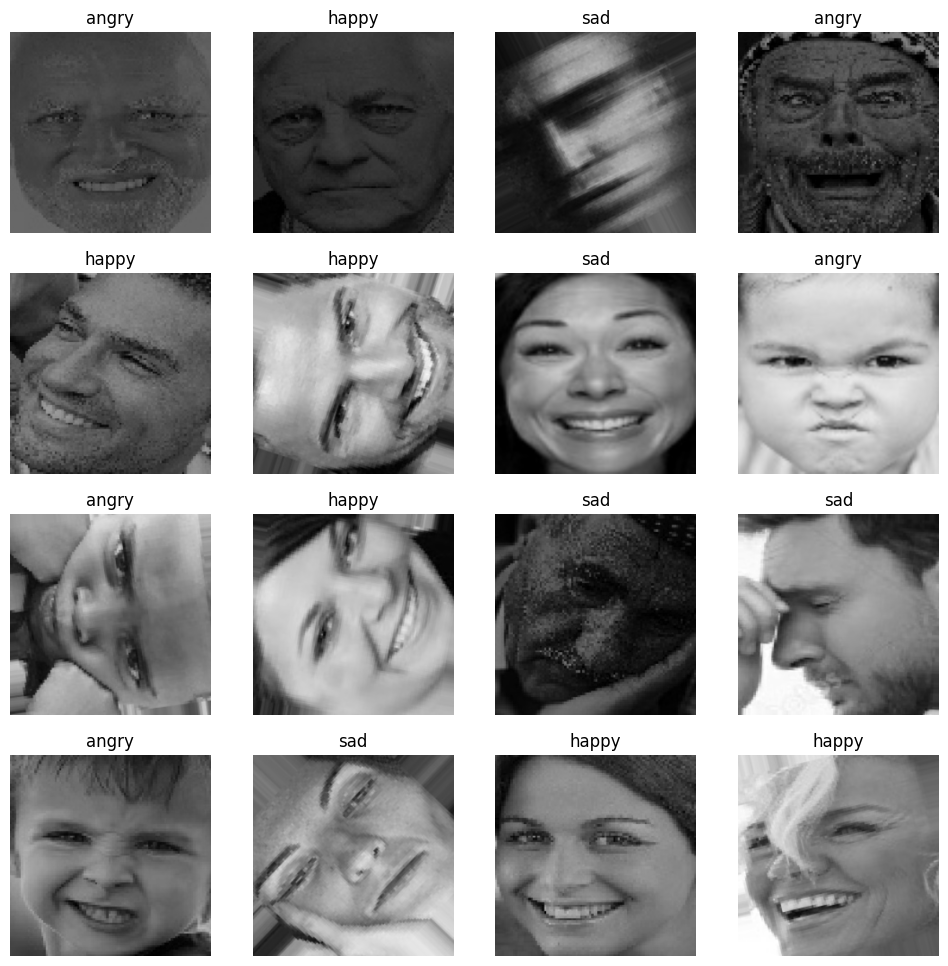

In [10]:
plt.figure(figsize=(12,12))

for images,labels in training_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis("off")

## Data Augmentation

In [11]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025,0.025),),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])
# factor 0.025 means 0.025*360 = 9 -> image will take random rotation of 9 degree.

In [12]:
@tf.function
def augment_layer(image,label):
    return augment_layers(image,training=True),label

### Cutmix augmentation

In [26]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [27]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [13]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
# we do augmantation only for training data
train_data = (training_dataset
              .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
              .prefetch(tf.data.AUTOTUNE))
val_data = (validation_dataset.prefetch(tf.data.AUTOTUNE))

In [16]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

### Cutmix Data Preparation

In [24]:
cutmix_dataset_1 = training_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
cutmix_dataset_2 = training_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((cutmix_dataset_1,cutmix_dataset_2))

In [28]:
cutmix_train_data = (mixed_dataset
                        .map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
                        .prefetch(tf.data.AUTOTUNE))

## Modeling

In [17]:
model = tf.keras.Sequential([
    Input(shape=(None,None,3)),
    resize_rescale_layer,

    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],strides=CONFIGURATION["N_STRIDES"],
           padding='valid',activation='relu',kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"],strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],strides=CONFIGURATION["N_STRIDES"],
           padding='valid',activation='relu',kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"],strides=CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation="relu",kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    Dense(CONFIGURATION["N_DENSE_2"], activation="relu",kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## Training

In [18]:
loss_function = SparseCategoricalCrossentropy()

### Difference between SparseCategoricalCrossentropy and CategoricalCrossentropy

In [77]:
y_true = [[0,1,0],[0,0,1]]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
cce = CategoricalCrossentropy()
cce(y_true,y_pred).numpy()

1.1769392

In [78]:
y_true = [[0,1,0],[0,0,1]]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
cce = SparseCategoricalCrossentropy()   # will give error
cce(y_true,y_pred).numpy()

ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(6,) and logits.shape=(2, 3)

In [79]:
y_true = [1,2]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
cce = SparseCategoricalCrossentropy()   # will give error
cce(y_true,y_pred).numpy()

1.1769392

In [20]:
metrics = [CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

In [21]:
model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [29]:
history = model.fit(cutmix_train_data,   # use only train data if not applying augmentation
                    # epochs=1,
                    epochs=CONFIGURATION["N_EPOCHS"],
                    validation_data=val_data,
                    verbose=1)

Epoch 1/20
172/213 [=======================>......] - ETA: 19s - loss: 0.9554 - accuracy: 0.2366 - top_k_accuracy: 0.5441

KeyboardInterrupt: 

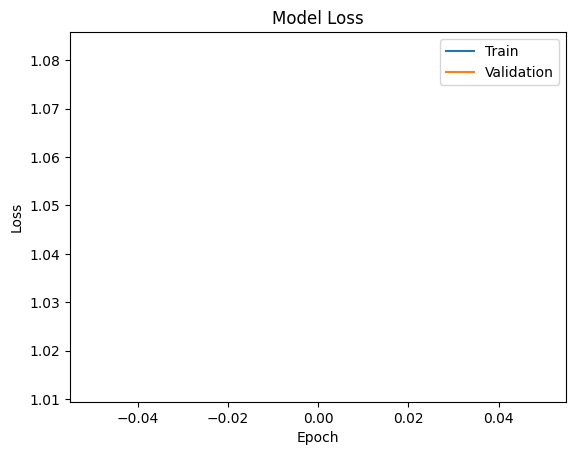

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

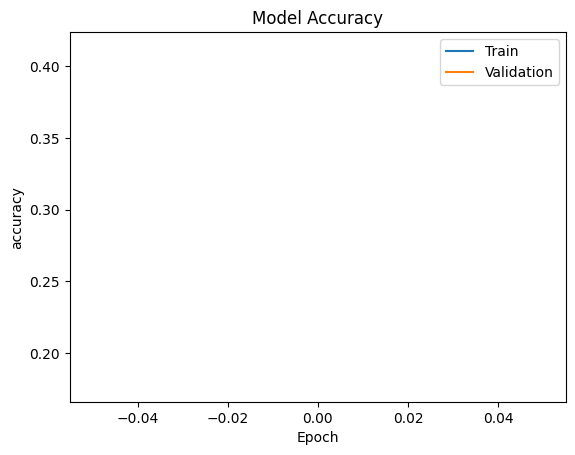

In [155]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluation

In [156]:
model.evaluate(val_data)

72/72 [==============================] - 38s 521ms/step - loss: 1.0824 - accuracy: 0.4122 - top_k_accuracy: 0.8898


[1.082371711730957, 0.41220369935035706, 0.889815628528595]

## Testing

In [157]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/104188.jpg_rotation_2.jpg")
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im,axis=0)

print(CLASS_NAMES[tf.argmax(model(im),axis=-1).numpy()[0]])

angry


In [158]:
# sad example
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/10416.jpg_rotation_2.jpg")
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im,axis=0)

print(CLASS_NAMES[tf.argmax(model(im),axis=-1).numpy()[0]])

angry


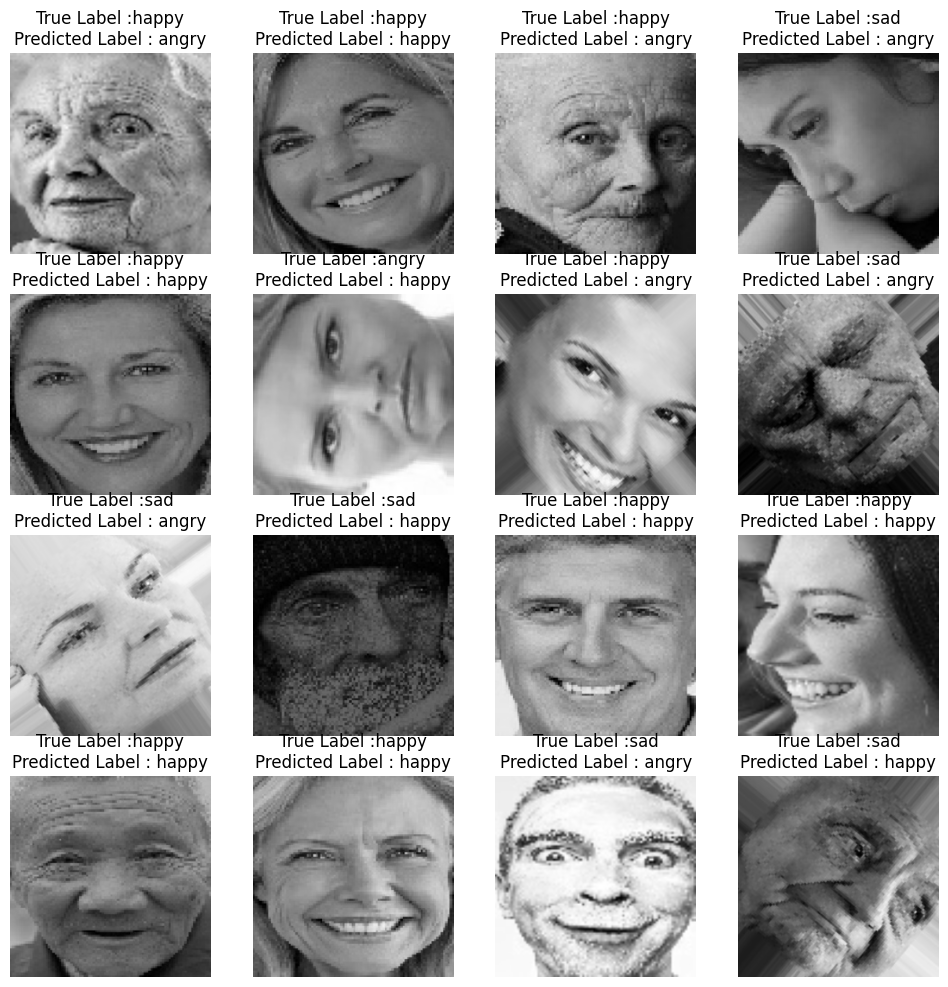

In [159]:
plt.figure(figsize=(12,12))

for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label :" + CLASS_NAMES[labels[i].numpy()] + "\n" + "Predicted Label : "+ CLASS_NAMES[tf.argmax(model(tf.expand_dims(images[i],axis=0)),axis=-1).numpy()[0]])
        plt.axis("off")

## Confusion Matrix

In [133]:
labels = []
predicted = []
for im, label in validation_dataset:
    labels.append(label.numpy())
    predicted.append(tf.argmax(model(im),axis=-1).numpy())

In [136]:
lab = np.concatenate(labels)
pred = np.concatenate(predicted)

In [137]:
lab

array([0, 2, 1, ..., 1, 1, 1], dtype=int32)

[[ 82 398  35]
 [  1 988  17]
 [ 10 659  88]]


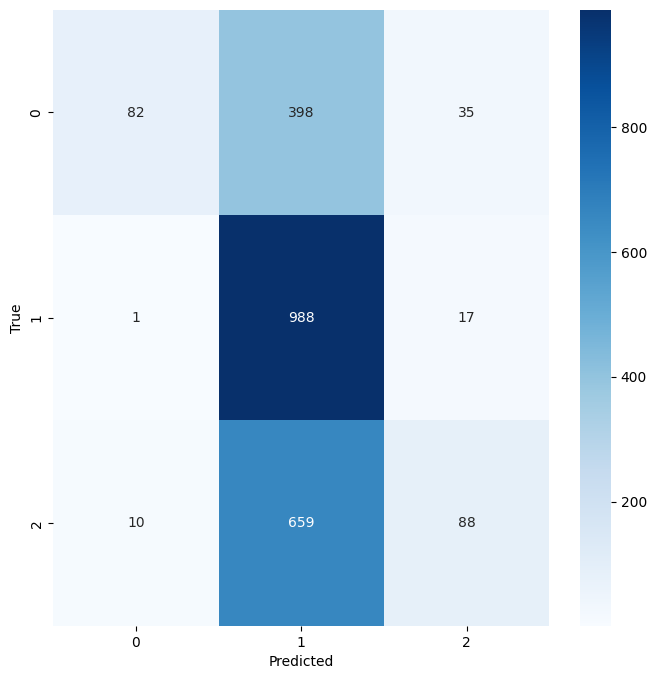

In [141]:
threshold = 0.5

cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Dataset Sharding using Tensorflow Records

we can make some shards or packs from the images we have and store it somewhere else with preprocesing. so we do not have to alot of images and instead we load this shards and convert back it to dataset.

*  More Efficient then  Tensorflow Dataset



In [30]:
# unbatch data if batched
training_dataset = training_dataset.unbatch()
validation_dataset = validation_dataset.unbatch()

In [32]:
training_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [44]:
def create_example(image,label):
    int_feature = Feature(int64_list=Int64List(value=[label]))
    # float feature is not available with this dataset
    # float_feature = Feature(float_list=FloatList(value=[1.0,2.0,3.0]))
    bytes_feature = Feature(bytes_list=BytesList(value=[image]))
    # labels are int feature and images are bytes


    example = Example(
        features=Features(feature = {
        'labels' : int_feature,
        # 'my_floats' : float_feature,
        'images' : bytes_feature
    }))

    return example.SerializeToString() # searialized example

In [34]:
# Now we create shards or parts of dataset
NUM_SHARDS = 10
PATH = "tfrecords/train_shard{:02d}.tfrecord"  # make sure tfrecords folder is available

In [38]:
# we need to encode image to convert it into bytes
def encode_image(image,label):
    image = tf.image.convert_image_dtype(image,dtype=tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image,label   # if labels are onehot encoded like [1 0 0] then use tf.argmax(label) in return

In [39]:
encoded_dataset = training_dataset.map(encode_image)

In [45]:
for shard_number in range(NUM_SHARDS):
    sharded_dataset = encoded_dataset.shard(NUM_SHARDS,shard_number).as_numpy_iterator()

    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for image,label in sharded_dataset:
            file_writer.write(create_example(image,label))


# Now shards are created in tfrecords directory and we can save it in drive or
# whichever location we want and whenever needed we can use it back by converting
# it back to tensorflow dataset

### Converting tfrecords to Tensorflow dataset and training model

In [46]:
sharded_files = [PATH.format(p) for p in range(NUM_SHARDS)]

In [47]:
sharded_files

['tfrecords/train_shard00.tfrecord',
 'tfrecords/train_shard01.tfrecord',
 'tfrecords/train_shard02.tfrecord',
 'tfrecords/train_shard03.tfrecord',
 'tfrecords/train_shard04.tfrecord',
 'tfrecords/train_shard05.tfrecord',
 'tfrecords/train_shard06.tfrecord',
 'tfrecords/train_shard07.tfrecord',
 'tfrecords/train_shard08.tfrecord',
 'tfrecords/train_shard09.tfrecord']

In [48]:
reconstruct_tfdataset = tf.data.TFRecordDataset(filenames=sharded_files)

In [49]:
# we need to parse this reconstructed dataset to get back images and label

def parse_tfrecords(example):

    feature_description = {
        "images" : tf.io.FixedLenFeature([],tf.string),
        "labels" : tf.io.FixedLenFeature([],tf.int64)
    }

    example = tf.io.parse_single_example(example,feature_description)
    example["images"] = tf.io.decode_jpeg(example["images"],channels=3)

    return example["images"],example["labels"]


In [55]:
parsed_dataset = reconstruct_tfdataset.map(parse_tfrecords).batch(CONFIGURATION["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)

In [57]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [56]:
for i in parsed_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=uint8, numpy=
array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 2

In [60]:
## training model with parsed data

history = model.fit(parsed_dataset,   # use only train data if not applying augmentation
                    # epochs=1,
                    epochs=CONFIGURATION["N_EPOCHS"],
                    validation_data=val_data,
                    verbose=1)

Epoch 1/20
213/213 [==============================] - 11s 41ms/step - loss: 0.9306 - accuracy: 0.1277 - top_k_accuracy: 0.5693 - val_loss: 1.2285 - val_accuracy: 0.2809 - val_top_k_accuracy: 0.6076
Epoch 2/20
213/213 [==============================] - 8s 38ms/step - loss: 0.5472 - accuracy: 0.1508 - top_k_accuracy: 0.4605 - val_loss: 1.6255 - val_accuracy: 0.2616 - val_top_k_accuracy: 0.6286
Epoch 3/20
213/213 [==============================] - 10s 48ms/step - loss: 0.3998 - accuracy: 0.1643 - top_k_accuracy: 0.4848 - val_loss: 2.1924 - val_accuracy: 0.3213 - val_top_k_accuracy: 0.7098
Epoch 4/20
213/213 [==============================] - 8s 35ms/step - loss: 0.3440 - accuracy: 0.1753 - top_k_accuracy: 0.5088 - val_loss: 2.5971 - val_accuracy: 0.3911 - val_top_k_accuracy: 0.8042
Epoch 5/20
213/213 [==============================] - 8s 39ms/step - loss: 0.3271 - accuracy: 0.1833 - top_k_accuracy: 0.5071 - val_loss: 2.2169 - val_accuracy: 0.1914 - val_top_k_accuracy: 0.5386
Epoch 6/20
21